В качестве домашнего задания мы предлагаем вам решить задачу бинарной классификации на большом корпусе imdb рецензий на фильмы. 
Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/

Ваша задача в sklearn, используя один из алгоритмов, рассмотренных на паре, построить и обучить классификатор, посчитать метрики качества, построить ROC кривую и посчитайте величину ROC AUC.  - 4 балла

Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели.  - 3 балла

Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками). - 3 балла

Дедлайн - 11 октября 23:59

In [ ]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-10-16 09:12:32--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  24.5MB/s    in 3.8s    

2020-10-16 09:12:36 (21.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
! tar xvzf aclImdb_v1.tar.gz

In [ ]:
%cd aclImdb

/content/aclImdb


In [ ]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [ ]:
train = pd.DataFrame(columns=['text', 'rate'])

In [ ]:
for file in os.listdir('train/neg'):
    f = open('train/neg' + os.sep + file, 'r')
    train.loc[len(train)] = [f.read(), 0]
    f.close()

In [ ]:
for file in os.listdir('train/pos'):
    f = open('train/pos' + os.sep + file, 'r')
    train.loc[len(train)] = [f.read(), 1]
    f.close()

In [ ]:
train.head()

,text,rate
0,Overall an extremely disappointing picture. Ve...,0
1,I saw this movie way back when it premiered.<b...,0
2,The Fluffer may have strong elements of porn i...,0
3,this is without a doubt the worst most idiotic...,0
4,Once big action star who fell off the face of ...,0


In [ ]:
test = pd.DataFrame(columns=['text', 'rate'])

In [ ]:
for file in os.listdir('test/neg'):
    f = open('test/neg' + os.sep + file, 'r')
    test.loc[len(test)] = [f.read(), 0]
    f.close()

In [ ]:
for file in os.listdir('test/pos'):
    f = open('test/pos' + os.sep + file, 'r')
    test.loc[len(test)] = [f.read(), 1]
    f.close()

In [ ]:
test.head()

,text,rate
0,This movie was *good* relatively during the fi...,0
1,Spheeris used this documentary to push a stere...,0
2,** Black Dragons (1942) William Nigh ~ Bela Lu...,0
3,"I was expecting ""Born to Kill"" to be an exciti...",0
4,By far this is the worst Halloween movie ever ...,0


In [ ]:
len(train), len(test)

(25000, 25000)

In [ ]:
english_stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def lemmatize_text_eng(text):
    reg = re.compile('[^a-zA-Z ]')
    text = reg.sub('', text.lower().strip())
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    return lemmatized_output

In [ ]:
train.text[0]

"Overall an extremely disappointing picture. Very, very slow build up to the basic storyline. The role of Maria Schrader searching for her families secret past. (Every take seems to last forever\x85. There is really no rhythm in the film.) ***SPOILERS*** Her Mother Ruth is rescued from the Nazis, by a German woman, played by Katja Riemann. The entire character of Ruth is so one dimensional, so stereotypical. ***SPOILERS END*** The film cuts back and forth between present day New York and Berlin and Berlin 40s something. Please when you do that, give the audience an indication of what time exactly the story takes place. There is never a clear indication of time \x96 very annoying. Worst part is, the end. ***SPOILERS*** The entire show and jabber about the Jews being so terribly tormented, simply by a bureaucratic accident! Give me a break. That's how the Jews got out of the Rosenstrasse? The question of who freed the Jews is NEVER answered. Was is Goebels who freed them? Did Lean Fische

In [ ]:
lemmatize_text_eng(train.text[0])

'overall an extremely disappointing picture very very slow build up to the basic storyline the role of maria schrader searching for her family secret past every take seems to last forever there is really no rhythm in the film spoiler her mother ruth is rescued from the nazi by a german woman played by katja riemann the entire character of ruth is so one dimensional so stereotypical spoiler end the film cut back and forth between present day new york and berlin and berlin s something please when you do that give the audience an indication of what time exactly the story take place there is never a clear indication of time very annoying worst part is the end spoiler the entire show and jabber about the jew being so terribly tormented simply by a bureaucratic accident give me a break thats how the jew got out of the rosenstrasse the question of who freed the jew is never answered wa is goebels who freed them did lean fischer sleep with goebels in venice the film won an acting award for k r

In [ ]:
from tqdm.auto import tqdm

tqdm.pandas()

In [ ]:
train['clean'] = train['text'].progress_apply(lambda x: lemmatize_text_eng(x))

In [ ]:
test['clean'] = test['text'].progress_apply(lambda x: lemmatize_text_eng(x))

In [ ]:
vectorizer = TfidfVectorizer(stop_words=english_stopwords,
                             max_features=40000)

X_tfidf = vectorizer.fit_transform(train.clean)

In [ ]:
X_test = vectorizer.transform(test.clean)

In [ ]:
clf = LogisticRegression().fit(X_tfidf, train['rate'].astype('int'))
y_pred = clf.predict(X_test)

In [ ]:
y_true = test['rate'].astype('int')

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}, P={1:1.4f}, R={2:1.4f}'.format(f1, precision, recall))

acc=0.8798
F1=0.8797, P=0.8804, R=0.8789


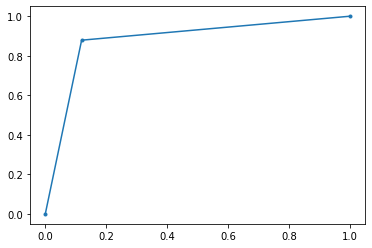

In [ ]:
fpr, tpr, thrhld = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, marker='.', label='Test')

In [ ]:
print(roc_auc_score(y_true, y_pred))

0.8797600000000001


In [ ]:
probs = clf.predict_proba(X_test)

In [ ]:
clf.classes_

array([0, 1])

In [ ]:
test['prob_neg'] = probs[:,0]

In [ ]:
test['prob_pos'] = probs[:,1]

In [ ]:
test.head()

,text,rate,clean,prob_neg,prob_pos
0,This movie was *good* relatively during the fi...,0,this movie wa good relatively during the first...,0.985498,0.014502
1,Spheeris used this documentary to push a stere...,0,spheeris used this documentary to push a stere...,0.642608,0.357392
2,** Black Dragons (1942) William Nigh ~ Bela Lu...,0,black dragon william nigh bela lugosi joan bar...,0.626204,0.373796
3,"I was expecting ""Born to Kill"" to be an exciti...",0,i wa expecting born to kill to be an exciting ...,0.802252,0.197748
4,By far this is the worst Halloween movie ever ...,0,by far this is the worst halloween movie ever ...,0.954794,0.045206


In [ ]:
test.sort_values('prob_neg', ascending=False).text[:15]

9186     As you can tell from the other comments, this ...
7491     This movie was a complete waste of time. The s...
3806     I rented this movie today... worst movie EVER....
4806     This was truly horrible. Bad acting, bad writi...
8167     This movie is pathetic in every way possible. ...
4655     This is just the same old crap that is spewed ...
3706     This is the worst movie I have ever seen. If I...
9464     This movie sucks. The acting is worse than in ...
10708    No idea how this is rated as high as it is (5....
8813     I'm in a film class and i know that i don't kn...
12023    For years I hesitated watching this movie. Now...
8719     One of the worst movies I've ever seen!!! Abso...
9709     If you are planning to watch 'Partner' and are...
9437     I bought this movie sight unseen at a sci-fi c...
8070     This is my first comment on a movie in here. I...
Name: text, dtype: object

In [ ]:
test.sort_values('prob_pos', ascending=False).text[:15]

24088    I think this is one of the best tamil movies i...
18334    What a wonderful film, filled with eccentric, ...
15764    This particular film was one that I wanted to ...
16244    I loved this movie - the actors were wonderful...
16872    A beautiful, magical, thought-provoking and he...
23667    Yes, it's not a great cinematic achievement, b...
21900    First of all, I have watched this show since I...
18656    I play final fantasy 7, and this movie is EXCE...
17906    This is a really great film in the pulp fictio...
21359    Best Years of Our Lives perfectly captures the...
22954    Went to the premiere at the Tribeca Film Festi...
23581    lovely. i just love the movie. i want to see t...
21634    Crossfire is a fantastic film noir that is bot...
24148    Wow! Fantastic film in my opinion, i wasn't ex...
20746    What a great movie!! It's a touching story abo...
Name: text, dtype: object

In [ ]:
def all_metrics(y_true, y_pred):

    quality = pd.DataFrame({'true': y_true, 'pred': y_pred})

    tp = len(quality[(quality.true == 1) & (quality.pred == 1)])
    fp = len(quality[(quality.true == 0) & (quality.pred == 1)])
    tn = len(quality[(quality.true == 0) & (quality.pred == 0)])
    fn = len(quality[(quality.true == 1) & (quality.pred == 0)])

    acc = (tp + tn) / (tp + tn + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1_score = (2 * precision * recall) / (precision + recall)

    return acc, precision, recall, f1_score

In [ ]:
my_acc, my_p, my_r, my_f = all_metrics(y_true, y_pred)

In [ ]:
my_acc == acc

True

In [ ]:
my_p == precision

True

In [ ]:
my_r == recall

True

In [ ]:
my_f == f1

True